# [Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/)

## Building Blocks: The Augmented LLM

In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field

In [ ]:
llm = ChatOllama(
    model=os.getenv("ollama_model"),
    reasoning=True,
)

In [ ]:
# Schema for structured output
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(None, description="Why this query is relevant to the user's request.")

In [ ]:
# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

In [ ]:
# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

In [ ]:
output

In [ ]:
# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

In [ ]:
# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

In [ ]:
# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

In [ ]:
# Get the tool call
msg.tool_calls

## Prompt chaining

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [ ]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [ ]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

In [ ]:
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

In [ ]:
def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

In [ ]:
# Build workflow
workflow = StateGraph(State)

In [ ]:
# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

In [ ]:
# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

In [ ]:
# Compile
chain = workflow.compile()

In [ ]:
g = chain.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [ ]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

## Parallelization

In [ ]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [ ]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

In [ ]:
# Build workflow
parallel_builder = StateGraph(State)

In [ ]:
# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

In [ ]:
# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

In [ ]:
g = parallel_workflow.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [ ]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

## Routing

In [ ]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage

In [ ]:
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

In [ ]:
# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [ ]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [ ]:
# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

In [ ]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

In [ ]:
# Build workflow
router_builder = StateGraph(State)

In [ ]:
# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

In [ ]:
# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

In [ ]:
# Compile workflow
router_workflow = router_builder.compile()

In [ ]:
g = router_workflow.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [ ]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

In [ ]:
state["decision"]

## Orchestrator-Worker

In [ ]:
from typing import Annotated, List, Sequence, cast
import operator
from langgraph.types import Send
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages

In [ ]:
# tool = TavilySearch(max_results=2)
# tools = [tool]
# llm_with_tools = llm.bind_tools(tools)

In [ ]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )

In [ ]:
class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

In [ ]:
# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [ ]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

In [ ]:
# Worker state
class WorkerState(TypedDict):
    # messages: Annotated[Sequence[AnyMessage], add_messages]
    section: Section
    completed_sections: Annotated[list, operator.add]

In [ ]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

    # """Worker writes a section of the report (with tool support)."""

    # # 1) 기존 대화맥락 + 섹션 가이드로 프롬프트 구성
    # prompt_msgs = list(state["messages"]) + [
    #     SystemMessage(
    #         content=(
    #             "Write a report section following the provided name and description. "
    #             "Include no preamble for each section. Use markdown formatting."
    #         )
    #     ),
    #     HumanMessage(
    #         content=(
    #             f"Section name: {state['section'].name}\n"
    #             f"Section description: {state['section'].description}"
    #         )
    #     ),
    # ]

    # # 2) 툴콜 가능한 LLM으로 호출 → AIMessage가 돌아오도록 유지
    # ai = cast(AIMessage, llm_with_tools.invoke(prompt_msgs))

    # # 3) 기본적으로 메시지에 append
    # updates: dict = {"messages": [ai]}

    # # 4) 마지막 AIMessage에 tool_calls가 없을 때만 섹션 완료로 기록
    # if not getattr(ai, "tool_calls", None):
    #     updates["completed_sections"] = [ai.content]

    # return updates


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

In [ ]:
# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

In [ ]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

In [ ]:
# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
# tool_node = ToolNode(tools=tools)
# orchestrator_worker_builder.add_node("tools", tool_node)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

In [ ]:
# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
# orchestrator_worker_builder.add_conditional_edges(
#     "llm_call",
#     tools_condition,
#     {"tools":"tools", END:"synthesizer"}
# )
# orchestrator_worker_builder.add_edge("tools", "llm_call")
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

In [ ]:
# Compile the workflow
memory = InMemorySaver()
orchestrator_worker = orchestrator_worker_builder.compile(checkpointer=memory)

In [ ]:
g = orchestrator_worker.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [ ]:
# Invoke
config = {"configurable": {"thread_id": "1"}}
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"}, config=config)

In [ ]:
from IPython.display import Markdown
Markdown(state["final_report"])

In [ ]:
state["sections"]

## Evaluator-optimizer

In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Annotated, List, Sequence, cast
import operator
from langgraph.types import Send
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages
from IPython.display import Markdown

In [ ]:
llm = ChatOllama(
    model=os.getenv("ollama_model"),
    reasoning=True,
)

In [ ]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [ ]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )

In [ ]:
# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [ ]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

In [ ]:
# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

In [ ]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

In [ ]:
g = optimizer_workflow.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [ ]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

## Agent

In [1]:
from langchain_core.tools import tool
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Annotated, List, Sequence, cast
import operator
from langgraph.types import Send
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from langgraph.graph.message import add_messages
from IPython.display import Markdown

In [2]:
llm = ChatOllama(
    model=os.getenv("ollama_model"),
    reasoning=True,
)

In [3]:
# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [4]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["Action", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

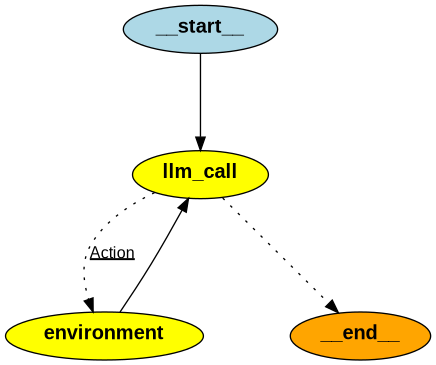

In [5]:
g = agent.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [6]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (902f2db9-6011-4c7d-81ab-983c927b07a4)
 Call ID: 902f2db9-6011-4c7d-81ab-983c927b07a4
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The result of adding 3 and 4 is **7**.


In [7]:
from langgraph.prebuilt import create_react_agent

# Pass in:
# (1) the augmented LLM with tools
# (2) the tools list (which is used to create the tool node)
pre_built_agent = create_react_agent(llm, tools=tools)

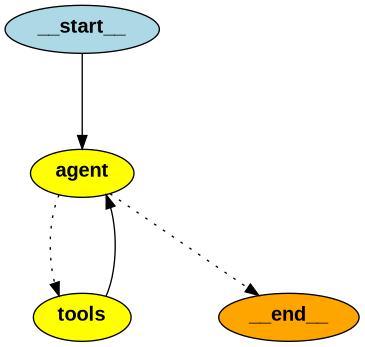

In [8]:
g = pre_built_agent.get_graph()
png = g.draw_png()     # pygraphviz + graphviz 필요
display(Image(png))

In [9]:
# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = pre_built_agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (b4092e7a-60f4-419f-807c-68896a0ddc25)
 Call ID: b4092e7a-60f4-419f-807c-68896a0ddc25
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is **7**.
